# Customer Purchasing Behavior Analysis

## Assignment Overview

This comprehensive analysis examines customer purchasing patterns from a UK-based online retail dataset using advanced machine learning techniques. The assignment integrates three major analytical approaches:

1. **Customer Clustering**: Segment customers based on purchasing behavior (spending, frequency, basket size)
2. **Deep Learning Embeddings**: Apply autoencoders to discover non-linear customer patterns
3. **Association Rule Mining**: Identify frequently co-purchased product combinations

## Business Objectives

- Identify distinct customer segments for targeted marketing
- Discover high-value customer populations
- Uncover product affinity patterns for cross-selling opportunities
- Compare traditional (PCA) vs. modern (deep learning) dimensionality reduction techniques
- Provide actionable business recommendations based on data insights

## Dataset Information

- **Source**: Online Retail II Dataset (UK-based e-commerce)
- **Time Period**: Retail transactions over multiple years
- **Initial Records**: 1,067,371 transactions
- **Data Quality**: Includes cancelled orders, missing descriptions, and negative quantities
- **Key Features**: Customer ID, Product Description, Quantity, Price, Transaction Date
- **Processing**: Cleaned to remove invalid records, resulting in 1,042,727 valid transactions
- **Customers**: 5,881 unique customers analyzed
- **Products**: 5,426 unique product items identified

## Notebook Structure

This notebook is organized into 4 main parts with clear step-by-step progression:

- **Part A**: Data Cleaning & Customer Clustering (k-Means & DBSCAN)
- **Part B**: Deep Embedding Clustering (Autoencoder + k-Means)
- **Part C**: Association Rule Mining (Apriori Algorithm)
- **Part D**: Interpretation & Business Recommendations


___


#### Load all required libraries


In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models

from mlxtend.frequent_patterns import fpgrowth, association_rules

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
print("Successfully imported libraries")


Successfully imported libraries


## Part A: Data Cleaning & Customer Clustering

### A1. Load Dataset

In [2]:
# Load the dataset
file_path = "online_retail_II.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Load dataset basic informaton

In [3]:
# Display dataset information and statistics
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### A2. Data cleaning

Remove missing descriptions, negative quantities, and cancelled invoices.


In [4]:
df_clean = df.copy()
df_clean.columns = [col.strip().replace(" ", "") for col in df_clean.columns]

df_clean = df_clean.dropna(subset=["Description"])
df_clean = df_clean[df_clean["Quantity"] > 0]
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.startswith("C")]
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("Removed rows:", df.shape[0] - df_clean.shape[0])
df_clean.head(5)


Original shape: (1067371, 8)
Cleaned shape: (1042727, 9)
Removed rows: 24644


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### A3. Create Customer-level Features
Create customer-level features: total spending, transaction count, and average basket size

In [6]:
# Aggregate customer-level features: TotalSpending, TransactionCount, AvgBasketSize
if 'TotalPrice' not in df_clean.columns and {'Quantity','UnitPrice'}.issubset(df_clean.columns):
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

customer_df = (
    df_clean
    .groupby("CustomerID")
    .agg(
        TotalSpending=("TotalPrice", "sum"),
        TransactionCount=("Invoice", "nunique"),
        TotalQty=("Quantity", "sum")
    )
    .reset_index()
)

customer_df["AvgBasketSize"] = (
    customer_df["TotalQty"] / customer_df["TransactionCount"].replace({0: np.nan})
)

print("Customers aggregated:", customer_df.shape[0])
display(customer_df.head(10))


Customers aggregated: 5881


,CustomerID,TotalSpending,TransactionCount,TotalQty,AvgBasketSize
0,12346.0,77556.46,12,74285,6190.416667
1,12347.0,5633.32,8,3286,410.750000
2,12348.0,2019.40,5,2714,542.800000
3,12349.0,4428.69,4,1624,406.000000
4,12350.0,334.40,1,197,197.000000
5,12351.0,300.93,1,261,261.000000
6,12352.0,2849.84,10,724,72.400000
7,12353.0,406.76,2,212,106.000000
8,12354.0,1079.40,1,530,530.000000
9,12355.0,947.61,2,543,271.500000


### A3.2. Prepare Features for Clustering

- Apply k-Means and DBSCAN
-Find optimal number of clusters silhouette score

In [7]:
# Prepare feature matrix: TotalSpending, TransactionCount, AvgBasketSize
features_kmeans = ["TotalSpending", "TransactionCount", "AvgBasketSize"]
X_kmeans = customer_df[features_kmeans].fillna(0).values

# Scale features for clustering
scaler_kmeans = StandardScaler()
X_scaled_kmeans = scaler_kmeans.fit_transform(X_kmeans)

print("Feature preparation for k-Means and DBSCAN:")
print(f"Features: {features_kmeans}")
print(f"X_scaled_kmeans shape: {X_scaled_kmeans.shape}")
print(f"\nFirst 5 rows of scaled features:")
print(pd.DataFrame(X_scaled_kmeans[:5], columns=features_kmeans))
print()

X_scaled = X_scaled_kmeans


Feature preparation for k-Means and DBSCAN:
Features: ['TotalSpending', 'TransactionCount', 'AvgBasketSize']
X_scaled_kmeans shape: (5881, 3)

First 5 rows of scaled features:
   TotalSpending  TransactionCount  AvgBasketSize
0       5.059391          0.439049       4.142494
1       0.177579          0.131635       0.109969
2      -0.067718         -0.098925       0.202101
3       0.095814         -0.175779       0.106655
4      -0.182088         -0.406339      -0.039166



#### A4.1. k-Means Clustering - Parameter Tuning

k-MEANS CLUSTERING - Parameter Tuning
__________________________________________________________________________________________


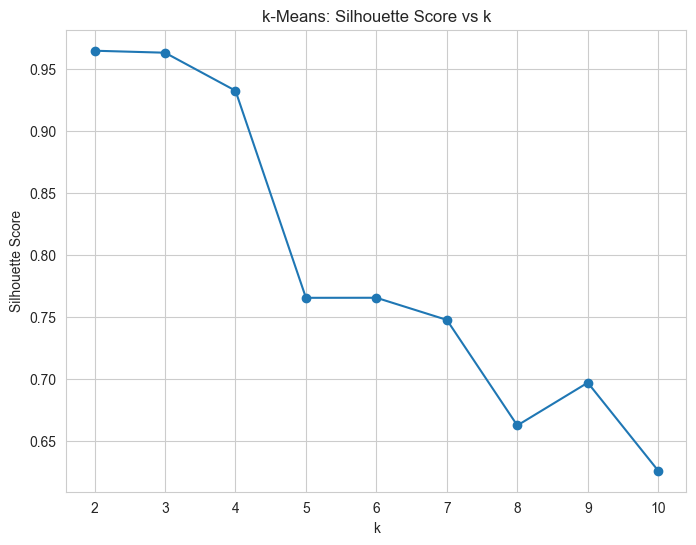


Silhouette scores for k=2..10:
  k=2: 0.9645 <-- OPTIMAL
  k=3: 0.9629
  k=4: 0.9323
  k=5: 0.7655
  k=6: 0.7655
  k=7: 0.7477
  k=8: 0.6626
  k=9: 0.6971
  k=10: 0.6261

------------------------------------------------------------------------------------------
k-MEANS FINAL RESULTS:
  Selected k: 2
  Number of clusters: 2
  Silhouette Score: 0.9645


In [8]:
# Tune k-Means: find optimal number of clusters using silhouette scores
print("k-MEANS CLUSTERING - Parameter Tuning")
print("_" * 90)
sil_scores = []
K_range = range(2, 11) 

for kk in K_range:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(8, 6))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("k-Means: Silhouette Score vs k")
plt.grid(True)
plt.show()

optimal_k = K_range[np.argmax(sil_scores)]
print(f"\nSilhouette scores for k=2..10:")
for k_val, sil_val in zip(K_range, sil_scores):
    marker = " <-- OPTIMAL" if k_val == optimal_k else ""
    print(f"  k={k_val}: {sil_val:.4f}{marker}")

# Apply k-Means with optimal k
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

print("\n" + "-" * 90)
print("k-MEANS FINAL RESULTS:")
print(f"  Selected k: {k}")
print(f"  Number of clusters: {n_clusters_kmeans}")
print(f"  Silhouette Score: {sil_kmeans:.4f}")


Tune DBSCAN: find optimal eps parameter using kNN distance plot

DBSCAN CLUSTERING - Parameter Tuning
______________________________________________________________________


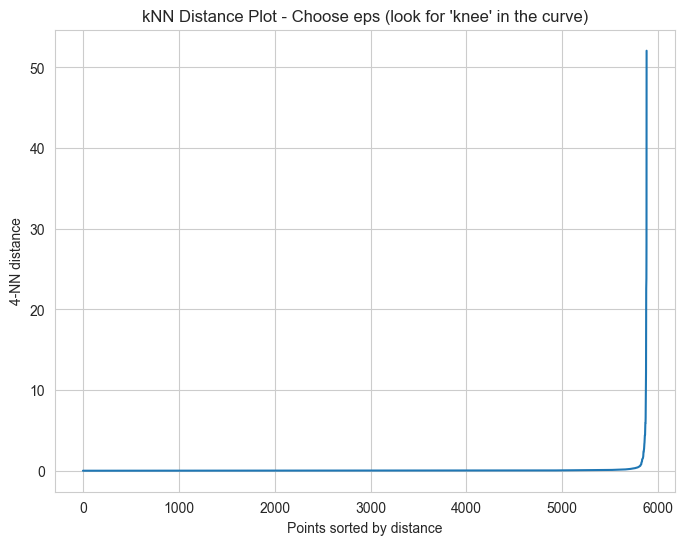


Testing different eps values for DBSCAN:
  eps=0.3: 3 clusters, 101 noise points, silhouette=0.6912 <-- OPTIMAL
  eps=0.5: 1 clusters, 69 noise points, silhouette=not meaningful
  eps=0.7: 2 clusters, 55 noise points, silhouette=0.8754 <-- OPTIMAL
  eps=1.0: 1 clusters, 54 noise points, silhouette=not meaningful
  eps=1.5: 1 clusters, 36 noise points, silhouette=not meaningful

----------------------------------------------------------------------
DBSCAN FINAL RESULTS:
  Selected eps: 0.7
  Number of clusters: 2
  Noise points: 55
  Silhouette Score: 0.8754 (excluding noise)


In [9]:
print("DBSCAN CLUSTERING - Parameter Tuning")
print("_" * 70)

neigh = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = neigh.kneighbors(X_scaled)
dists = np.sort(dists[:, 4])

plt.figure(figsize=(8, 6))
plt.plot(dists)
plt.ylabel("4-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("kNN Distance Plot - Choose eps (look for 'knee' in the curve)")
plt.grid(True)
plt.show()

print("\nTesting different eps values for DBSCAN:")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
best_eps = 0.7
best_sil = -1
best_n_clusters = 0
best_n_noise = 0

for eps_val in eps_values:
    dbscan_test = DBSCAN(eps=eps_val, min_samples=5)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    
    valid_mask = labels_test != -1
    if len(set(labels_test[valid_mask])) > 1:
        sil_test = silhouette_score(X_scaled[valid_mask], labels_test[valid_mask])
        marker = " <-- OPTIMAL" if sil_test > best_sil else ""
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil_test:.4f}{marker}")
        if sil_test > best_sil:
            best_sil = sil_test
            best_eps = eps_val
            best_n_clusters = n_clusters
            best_n_noise = n_noise
    else:
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette=not meaningful")

# Apply DBSCAN with optimal eps
dbscan = DBSCAN(eps=best_eps, min_samples=5)
customer_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    print(f"\n" + "-" * 70)
    print("DBSCAN FINAL RESULTS:")
    print(f"  Selected eps: {best_eps}")
    print(f"  Number of clusters: {n_clusters_dbscan}")
    print(f"  Noise points: {n_noise_dbscan}")
    print(f"  Silhouette Score: {sil_dbscan:.4f} (excluding noise)")


Compare k-Means and DBSCAN clustering results

In [13]:
# Compare k-Means and DBSCAN clustering results
print("CLUSTERING METHODS COMPARISON")
print("_" * 70)

n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    sil_dbscan_str = f"{sil_dbscan:.4f}"
else:
    sil_dbscan_str = "N/A (not meaningful)"

print(f"\n{'Metric':<30} {'k-Means':<20} {'DBSCAN':<20}")
print("-" * 70)
print(f"{'Number of clusters':<30} {n_clusters_kmeans:<20} {n_clusters_dbscan:<20}")
print(f"{'Silhouette Score':<30} {sil_kmeans:.4f}{'':<16} {sil_dbscan_str:<20}")
print(f"{'Noise points':<30} {'N/A (all assigned)':<20} {n_noise_dbscan:<20}")


CLUSTERING METHODS COMPARISON
______________________________________________________________________

Metric                         k-Means              DBSCAN              
----------------------------------------------------------------------
Number of clusters             2                    2                   
Silhouette Score               0.9645                 0.8754              
Noise points                   N/A (all assigned)   55                  


### A5. Visualize Clusters with PCA

Compute silhouette scores and visualize clusters using PCA projections

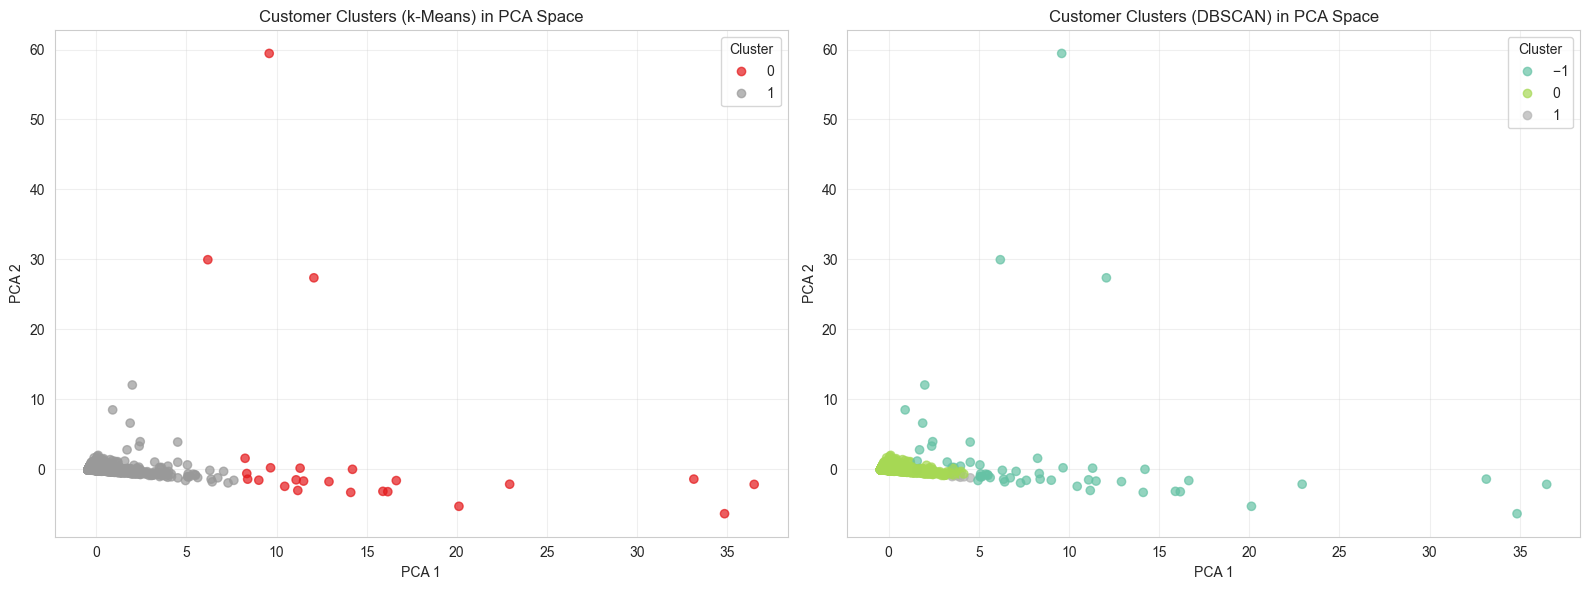

In [11]:
# Visualize clusters using PCA 2D projection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["kmeans_cluster"],
    cmap='Set1',
    alpha=0.7
)
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_title("Customer Clusters (k-Means) in PCA Space")
ax1.legend(*scatter1.legend_elements(), title="Cluster")
ax1.grid(True, alpha=0.3)

scatter2 = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["dbscan_cluster"],
    cmap='Set2',
    alpha=0.7
)
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_title("Customer Clusters (DBSCAN) in PCA Space")
ax2.legend(*scatter2.legend_elements(), title="Cluster")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### here is the Interpretation of k-Means vs DBSCAN Clustering Results

The k-Means algorithm partitions all customers into two clusters, with one dense cluster (grey) concentrated near the origin representing typical customers, and another more diffuse cluster (red) that includes potential outliers. In contrast, DBSCAN identifies two very compact, dense clusters near the origin (light green and grey) while explicitly labeling 55 scattered points as noise (light blue), demonstrating its ability to distinguish between genuine customer segments and anomalous purchasing patterns that k-Means would force into a cluster.


## Part B: Deep Embedding Clustering

Autoencoder latent embeddings clustered with k-Means


#### B1.1. Build autoencoder architecture for deep embedding clustering

In [17]:
input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation="relu")(input_layer)
bottleneck = layers.Dense(encoding_dim, activation="relu", name="bottleneck")(encoded)
decoded = layers.Dense(8, activation="relu")(bottleneck)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

#### B1.2. Train autoencoder

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8020 - val_loss: 1.9591
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7502 - val_loss: 1.8505
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7064 - val_loss: 1.7794
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6655 - val_loss: 1.7019
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6265 - val_loss: 1.6290
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5812 - val_loss: 1.5681
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5327 - val_loss: 1.4801
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4848 - val_loss: 1.4006
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4391 - val_loss: 1.3205
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3979 - val_loss: 1.2490
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3537 - val_loss: 1.1712
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3

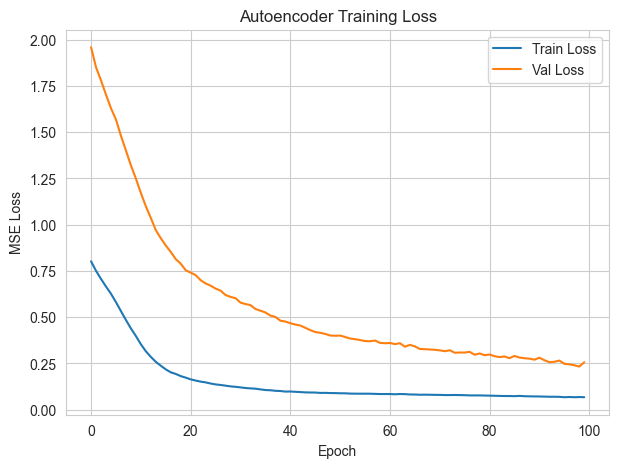

In [18]:
# Train the autoencoder
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(7, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


#### B2. # Extract latent space embeddings from the trained encoder and Cluster the embeddings using K-Means

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Autoencoder Embedding k-Means Silhouette Score: 0.9865


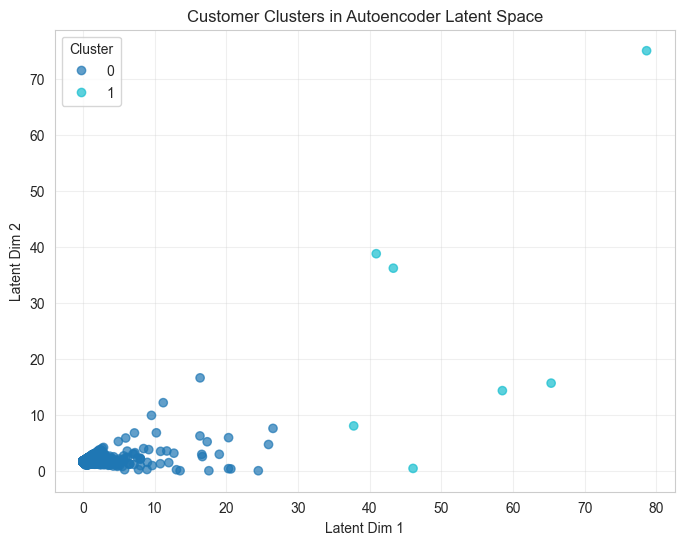

In [19]:
# Extract latent embeddings from trained autoencoder
encoder = models.Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("bottleneck").output)

embeddings = encoder.predict(X_scaled)

# Apply k-Means clustering on latent embeddings
kmeans_ae = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["ae_cluster"] = kmeans_ae.fit_predict(embeddings)

sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])
print(f"Autoencoder Embedding k-Means Silhouette Score: {sil_ae:.4f}")

# Visualize embeddings and clusters
plt.figure(figsize=(8, 6))
scatter_ae = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                         c=customer_df["ae_cluster"], cmap='tab10', alpha=0.7)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Customer Clusters in Autoencoder Latent Space")
plt.legend(*scatter_ae.legend_elements(), title="Cluster")
plt.grid(True, alpha=0.3)
plt.show()



B2.2. compare cluster quality with PCA clusters.

In [20]:
# Compare clustering quality: PCA vs Autoencoder embeddings
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_pca_cluster"] = kmeans_pca.fit_predict(X_pca_2d)

sil_pca = silhouette_score(X_pca_2d, customer_df["kmeans_pca_cluster"])
sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])

print("SILHOUETTE SCORE COMPARISON")
print("_" * 45)
print(f"k-Means on PCA (2D):        {sil_pca:.4f}")
print(f"k-Means on Autoencoder embeddings: {sil_ae:.4f}")
print("-" * 45)
print(f"Difference:                  {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"Autoencoder embeddings perform better by {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"PCA performs better by {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")


SILHOUETTE SCORE COMPARISON
_____________________________________________
k-Means on PCA (2D):        0.9659
k-Means on Autoencoder embeddings: 0.9865
---------------------------------------------
Difference:                  0.0206
Autoencoder embeddings perform better by 2.13%


##### B3.Visual comparison: PCA vs Autoencoder embeddings

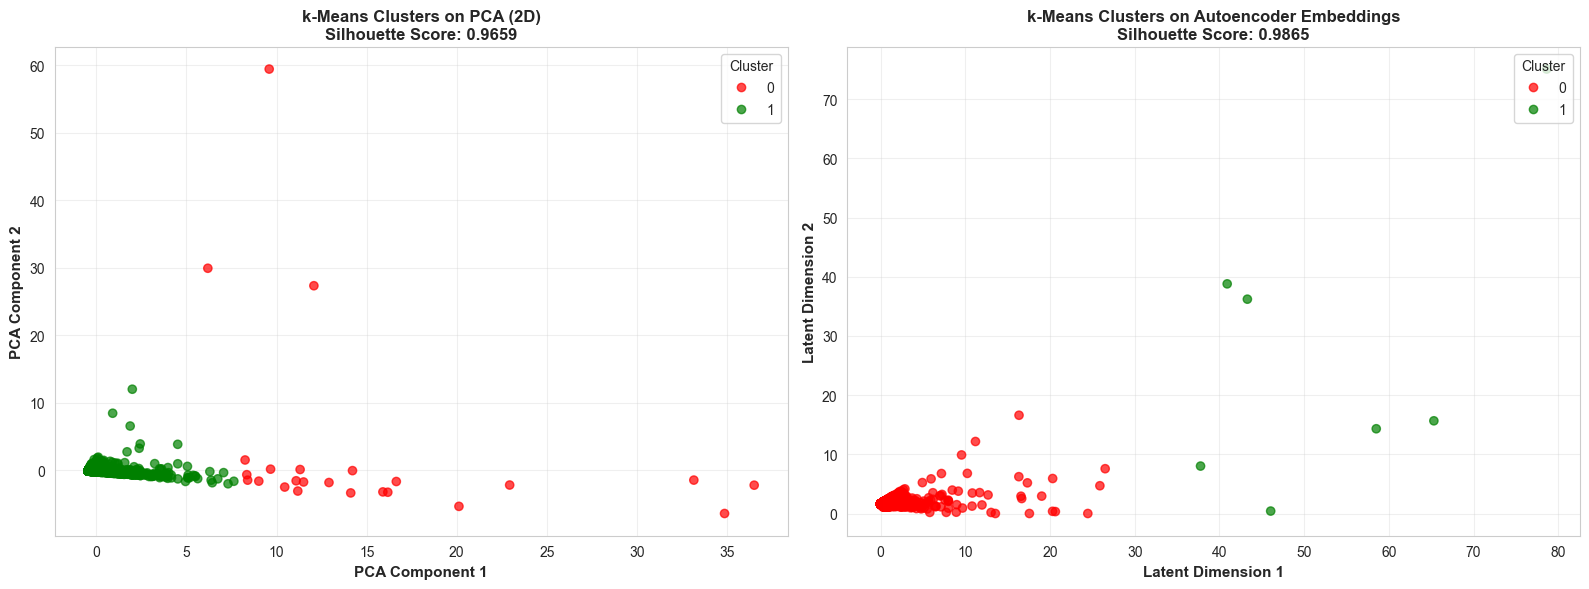

In [22]:

from matplotlib.colors import ListedColormap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ListedColormap(['red', 'green'])
scatter1 = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=customer_df["kmeans_pca_cluster"],
    alpha=0.7,
    cmap=colors
)
ax1.set_xlabel("PCA Component 1", fontsize=11, fontweight='bold')
ax1.set_ylabel("PCA Component 2", fontsize=11, fontweight='bold')
ax1.set_title(f"k-Means Clusters on PCA (2D)\nSilhouette Score: {sil_pca:.4f}", fontsize=12, fontweight='bold')
ax1.legend(*scatter1.legend_elements(), title="Cluster", loc='upper right')
ax1.grid(True, alpha=0.3)

scatter2 = ax2.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=customer_df["ae_cluster"],
    alpha=0.7,
    cmap=colors
)
ax2.set_xlabel("Latent Dimension 1", fontsize=11, fontweight='bold')
ax2.set_ylabel("Latent Dimension 2", fontsize=11, fontweight='bold')
ax2.set_title(f"k-Means Clusters on Autoencoder Embeddings\nSilhouette Score: {sil_ae:.4f}", fontsize=12, fontweight='bold')
ax2.legend(*scatter2.legend_elements(), title="Cluster", loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part C: Association Rule Mining


### 1. Convert Data into Basket Format

Convert data into basket format: Invoice to a list of Description items.

In [23]:
# Convert data into basket format: Invoice to a list of Description items
basket_df = (
    df_clean[["Invoice", "Description", "Quantity"]]
    .copy()
)

print("Basket format data preview:")
basket_df.head()


Basket format data preview:


,Invoice,Description,Quantity
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12
1,489434,PINK CHERRY LIGHTS,12
2,489434,WHITE CHERRY LIGHTS,12
3,489434,"RECORD FRAME 7"" SINGLE SIZE",48
4,489434,STRAWBERRY CERAMIC TRINKET BOX,24


### 2. Build Binary Matrix

Build binary matrix with Invoice as rows and Description as columns.

In [24]:
# Build binary matrix: Invoice as rows, Description as columns (True/False)
basket = (
    basket_df
    .groupby(["Invoice", "Description"])["Quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

basket_bool = basket > 0

print("Binary Matrix Created:")
print(f"Shape: {basket_bool.shape[0]} invoices × {basket_bool.shape[1]} products")
print(f"\nFirst 5 rows:")
basket_bool.head()


Binary Matrix Created:
Shape: 40301 invoices × 5469 products

First 5 rows:


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,tk maxx mix up with pink,to push order througha s stock was,update,website fixed,wrong invc,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489437,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489438,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3. Apply FP-Growth


In [25]:
# Apply FP-Growth algorithm to find frequent itemsets
frequent_itemsets = fpgrowth(
    basket_bool,
    min_support=0.01,
    use_colnames=True
)

print("Number of frequent itemsets:", len(frequent_itemsets))
print("\nTop 10 frequent itemsets:")
frequent_itemsets.head(10)


Number of frequent itemsets: 1056

Top 10 frequent itemsets:


,support,itemsets
0,0.057319,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.019330,(SAVE THE PLANET MUG)
2,0.017220,(PINK DOUGHNUT TRINKET POT )
3,0.013771,"(RECORD FRAME 7"" SINGLE SIZE )"
4,0.012828,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
5,0.069676,(ASSORTED COLOUR BIRD ORNAMENT)
6,0.051264,(HOME BUILDING BLOCK WORD)
7,0.042083,(LOVE BUILDING BLOCK WORD)
8,0.041910,(SCOTTIE DOG HOT WATER BOTTLE)
9,0.020669,(HEART IVORY TRELLIS LARGE)


### 4. Extract the 10 Strongest Rules Sorted by Lift

Extract the 10 strongest rules sorted by lift.

In [31]:
if 'frequent_itemsets' not in globals():
    raise NameError("Please run Cell 42 (Step 3) first to create frequent_itemsets.")

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
top_rules = rules.sort_values("lift", ascending=False).head(10)

print("TOP 10 STRONGEST ASSOCIATION RULES (Sorted by Lift)")
print(f"\nTotal rules generated: {len(rules)}")
print(f"\nTop 10 rules:\n")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]].to_string())


TOP 10 STRONGEST ASSOCIATION RULES (Sorted by Lift)

Total rules generated: 848

Top 10 rules:

                                                     antecedents                                                  consequents   support  confidence       lift
806      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)                              (POPPY'S PLAYHOUSE LIVINGROOM )  0.010149    0.734291  52.469247
807                              (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)  0.010149    0.725177  52.469247
805   (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE KITCHEN)                                 (POPPY'S PLAYHOUSE BEDROOM )  0.010149    0.862869  49.465849
808                                 (POPPY'S PLAYHOUSE BEDROOM )   (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE KITCHEN)  0.010149    0.581792  49.465849
804  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE BEDROOM )                                  (POPPY'S PL

### 5. Interpret at Least 3 Rules

Interpret at least 3 rules.

In [33]:
# Interpret at least 3 association rules
def frozenset_to_str(fset):
    return ", ".join(list(fset))

np.random.seed(42)
sampled_rules = top_rules.sample(n=min(4, len(top_rules)), random_state=42)

# Create a table for the rules
rules_data = []
for i, (idx, row) in enumerate(sampled_rules.iterrows(), 1):
    antecedents = frozenset_to_str(row["antecedents"])
    consequents = frozenset_to_str(row["consequents"])
    rules_data.append({
        'Rule': i,
        'If Customer Buys': antecedents,
        'Then They should buy also': consequents,
        'Support': f"{row['support']:.4f}",
        'Confidence': f"{row['confidence']:.4f}",
        'Lift': f"{row['lift']:.4f}"
    })

rules_df = pd.DataFrame(rules_data)
print("4 ASSOCIATION RULES FOR INTERPRETATION")
print()
display(rules_df)


4 ASSOCIATION RULES FOR INTERPRETATION



,Rule,If Customer Buys,Then They should buy also,Support,Confidence,Lift
0,1,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.0118,0.8404,45.6469
1,2,POPPY'S PLAYHOUSE LIVINGROOM,"POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE ...",0.0101,0.7252,52.4692
2,3,POPPY'S PLAYHOUSE KITCHEN,"POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOU...",0.0101,0.5512,48.1875
3,4,"POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE ...",POPPY'S PLAYHOUSE LIVINGROOM,0.0101,0.7343,52.4692


## Part D: Interpretation and Presentations

I describes cluster meanings and customer types, high-value segments, differences between PCA and deep embedding clusters, three actionable business recommendations.

### 1. Describe Cluster Meanings and Customer Types

Describe cluster meanings and customer types.


In [44]:
# Describe cluster profiles: cluster meanings and customer types
cluster_profile_kmeans = (
    customer_df
    .groupby("kmeans_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

cluster_counts_kmeans = customer_df.groupby("kmeans_cluster").size()
cluster_profile_kmeans['Customer_Count'] = cluster_counts_kmeans

cluster_profile_ae = (
    customer_df
    .groupby("ae_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

cluster_counts_ae = customer_df.groupby("ae_cluster").size()
cluster_profile_ae['Customer_Count'] = cluster_counts_ae

# Display cluster profiles in table format
print("CLUSTER PROFILES COMPARISON")
print("=" * 100)
print("\nk-Means Cluster Profiles:")
display(cluster_profile_kmeans)
print("\nAutoencoder Cluster Profiles:")
display(cluster_profile_ae)




CLUSTER PROFILES COMPARISON

k-Means Cluster Profiles:


,TotalSpending,TransactionCount,AvgBasketSize,Customer_Count
kmeans_cluster,,,,
0,163760.19,131.46,8009.53,24
1,2358.41,5.77,221.35,5857



Autoencoder Cluster Profiles:


,TotalSpending,TransactionCount,AvgBasketSize,Customer_Count
ae_cluster,,,,
0,2686.69,6.15,223.31,5874
1,280255.97,122.71,25277.98,7


In [35]:
# Cluster interpretations summary
print("\nCLUSTER INTERPRETATIONS")
print("_" * 80)
print()

print("k-MEANS CLUSTERS:")
for cluster in cluster_profile_kmeans.index:
    row = cluster_profile_kmeans.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 70000:
        desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS"
        char = f"  - High spending (£{spending:,.2f}), frequent transactions ({transactions:.1f}), large baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: MEDIUM-VALUE CUSTOMERS"
        char = f"  - Moderate spending (£{spending:,.2f}), occasional transactions ({transactions:.1f}), small-medium baskets (£{basket:,.2f})"
    
    print(f"{desc} ({count} customers, {pct:.1f}%)")
    print(char)
    print()

print("AUTOENCODER CLUSTERS:")
for cluster in cluster_profile_ae.index:
    row = cluster_profile_ae.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 190000:
        desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS"
        char = f"  - Very high spending (£{spending:,.2f}), frequent transactions ({transactions:.1f}), large baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: LOW-VALUE OCCASIONAL BUYERS"
        char = f"  - Low spending (£{spending:,.2f}), infrequent transactions ({transactions:.1f}), small baskets (£{basket:,.2f})"
    
    print(f"{desc} ({count} customers, {pct:.1f}%)")
    print(char)
    print()


CLUSTER INTERPRETATIONS
________________________________________________________________________________

k-MEANS CLUSTERS:
Cluster 0: HIGH-VALUE FREQUENT BUYERS (24 customers, 0.4%)
  - High spending (£163,760.19), frequent transactions (131.5), large baskets (£8,009.53)

Cluster 1: MEDIUM-VALUE CUSTOMERS (5857 customers, 99.6%)
  - Moderate spending (£2,358.41), occasional transactions (5.8), small-medium baskets (£221.35)

AUTOENCODER CLUSTERS:
Cluster 0: LOW-VALUE OCCASIONAL BUYERS (5874 customers, 99.9%)
  - Low spending (£2,686.69), infrequent transactions (6.2), small baskets (£223.31)

Cluster 1: HIGH-VALUE FREQUENT BUYERS (7 customers, 0.1%)
  - Very high spending (£280,255.97), frequent transactions (122.7), large baskets (£25,277.98)



### 2. Identify High-Value Segments

Identify high-value segments.


In [36]:
# Identify high-value segments: sort clusters by average total spending
high_value_clusters_kmeans = (
    cluster_profile_kmeans
    .sort_values("TotalSpending", ascending=False)
)

high_value_clusters_ae = (
    cluster_profile_ae
    .sort_values("TotalSpending", ascending=False)
)

print("HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_kmeans)
print()

print("\nHIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_ae)


HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):
________________________________________________________________________________
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                   163760.19            131.46        8009.53              24
1                     2358.41              5.77         221.35            5857


HIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):
________________________________________________________________________________
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
1               280255.97            122.71       25277.98               7
0                 2686.69              6.15         223.31            5874


### 3. Compare Differences Between PCA and Deep Embedding Clusters

Compare differences between PCA and deep embedding clusters.


In [43]:
# Compare differences between PCA and deep embedding clusters
print("COMPARISON: PCA vs Deep Embedding Clusters")
print("_" * 80)
print()
print("1. CLUSTERING QUALITY:")
print(f"   k-Means on PCA (2D):                    {sil_pca:.4f}")
print(f"   k-Means on Autoencoder embeddings:      {sil_ae:.4f}")
print(f"   Difference:                             {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"   Autoencoder performs better by:        {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"   PCA performs better by:                 {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")
print()
print("\n2. CLUSTER PROFILES COMPARISON:")
print("\n   k-Means Clusters (PCA-based):")
print(cluster_profile_kmeans)
print("\n   Autoencoder Clusters (Deep Embedding):")
print(cluster_profile_ae)
print()


COMPARISON: PCA vs Deep Embedding Clusters
________________________________________________________________________________

1. CLUSTERING QUALITY:
   k-Means on PCA (2D):                    0.9659
   k-Means on Autoencoder embeddings:      0.9865
   Difference:                             0.0206
   Autoencoder performs better by:        2.13%


2. CLUSTER PROFILES COMPARISON:

   k-Means Clusters (PCA-based):
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                   163760.19            131.46        8009.53              24
1                     2358.41              5.77         221.35            5857

   Autoencoder Clusters (Deep Embedding):
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
0                 2686.69              6.15         223.31            5874
1 

### 4. Three Actionable Business Recommendations

Provide three actionable business recommendations.

In [42]:

# Three Actionable Business Recommendations
print("THREE ACTIONABLE BUSINESS RECOMMENDATIONS")
print("_" * 80)
print()

# Recommendation 1: Cross-sell bundles from association rules
print("1. CROSS-SELL BUNDLES (Based on Association Rules):")
if 'sampled_rules' in globals() and len(sampled_rules) > 0:
    for i, (idx, row) in enumerate(sampled_rules.head(3).iterrows(), 1):
        antecedents = frozenset_to_str(row["antecedents"])
        consequents = frozenset_to_str(row["consequents"])
        print(f"   • Bundle {i}: When customers buy [{antecedents}],")
        print(f"     recommend [{consequents}] (Lift: {row['lift']:.2f}, Confidence: {row['confidence']:.2%})")
    print()
    print("   RECOMMENDATION:")
    print("   - Create product bundles based on these strong associations")
    print("   - Display 'Frequently Bought Together' recommendations on product pages")
    print("   - Offer bundle discounts (5-10% off) to incentivize cross-selling")
else:
    print("   (Run Section C5 first to see association rules)")
print()


THREE ACTIONABLE BUSINESS RECOMMENDATIONS
________________________________________________________________________________

1. CROSS-SELL BUNDLES (Based on Association Rules):
   • Bundle 1: When customers buy [POPPY'S PLAYHOUSE LIVINGROOM ],
     recommend [POPPY'S PLAYHOUSE KITCHEN] (Lift: 45.65, Confidence: 84.04%)
   • Bundle 2: When customers buy [POPPY'S PLAYHOUSE LIVINGROOM ],
     recommend [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN] (Lift: 52.47, Confidence: 72.52%)
   • Bundle 3: When customers buy [POPPY'S PLAYHOUSE KITCHEN],
     recommend [POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE BEDROOM ] (Lift: 48.19, Confidence: 55.12%)

   RECOMMENDATION:
   - Create product bundles based on these strong associations
   - Display 'Frequently Bought Together' recommendations on product pages
   - Offer bundle discounts (5-10% off) to incentivize cross-selling



In [41]:
# Recommendation 2: Loyalty programs for high-value segments
top_cluster_kmeans = high_value_clusters_kmeans.index[0]
top_cluster_ae = high_value_clusters_ae.index[0]

print("2. LOYALTY PROGRAMS (Based on High-Value Segments):")
print("   Target Segments:")
print(f"   • k-Means Cluster {top_cluster_kmeans}: Premium customers (£{high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count'])} customers ({high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TransactionCount']:.1f} transactions per customer on average")
print()
print(f"   • Autoencoder Cluster {top_cluster_ae}: High-value customers (£{high_value_clusters_ae.loc[top_cluster_ae, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count'])} customers ({high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_ae.loc[top_cluster_ae, 'TransactionCount']:.1f} transactions per customer on average")
print()
print("   RECOMMENDATION:")
print("   - Implement VIP loyalty program with tiered rewards:")
print("     * Exclusive early access to sales")
print("     * Free shipping on all orders")
print("     * Birthday discounts and personalized offers")
print("     * Points multiplier (2x-3x points per £1 spent)")
print("   - Focus retention efforts on these segments (highest lifetime value)")
print()


2. LOYALTY PROGRAMS (Based on High-Value Segments):
   Target Segments:
   • k-Means Cluster 0: Premium customers (£163,760.19 avg)
     - 24 customers (0.41% of total)
     - 131.5 transactions per customer on average

   • Autoencoder Cluster 1: High-value customers (£280,255.97 avg)
     - 7 customers (0.12% of total)
     - 122.7 transactions per customer on average

   RECOMMENDATION:
   - Implement VIP loyalty program with tiered rewards:
     * Exclusive early access to sales
     * Free shipping on all orders
     * Birthday discounts and personalized offers
     * Points multiplier (2x-3x points per £1 spent)
   - Focus retention efforts on these segments (highest lifetime value)



In [40]:
# Recommendation 3: Targeted discounts based on cluster characteristics
high_freq_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['TransactionCount'].idxmax()]
high_freq_ae = cluster_profile_ae.loc[cluster_profile_ae['TransactionCount'].idxmax()]
large_basket_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['AvgBasketSize'].idxmax()]
large_basket_ae = cluster_profile_ae.loc[cluster_profile_ae['AvgBasketSize'].idxmax()]

print("3. TARGETED DISCOUNTS (Based on Cluster Characteristics):")
print("-" * 80)
print("   High-Frequency Buyers:")
print(f"   • k-Means Cluster {high_freq_kmeans.name}: {high_freq_kmeans['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Offer 'Buy 10, Get 1 Free' loyalty cards")
print()
print(f"   • Autoencoder Cluster {high_freq_ae.name}: {high_freq_ae['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_ae['Customer_Count'])} customers")
print(f"     - Strategy: Monthly subscription discounts for regular purchases")
print()
print("   Large Basket Customers:")
print(f"   • k-Means Cluster {large_basket_kmeans.name}: £{large_basket_kmeans['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Volume discounts (10% off orders over £500)")
print()
print(f"   • Autoencoder Cluster {large_basket_ae.name}: £{large_basket_ae['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_ae['Customer_Count'])} customers")
print(f"     - Strategy: Progressive discounts (5% off £200+, 10% off £500+)")
print()
print("   RECOMMENDATION:")
print("   - Segment-specific email campaigns with personalized offers")
print("   - Time-limited promotions to encourage immediate purchases")
print("   - A/B test discount levels to optimize conversion rates")
print()

3. TARGETED DISCOUNTS (Based on Cluster Characteristics):
--------------------------------------------------------------------------------
   High-Frequency Buyers:
   • k-Means Cluster 0: 131.5 avg transactions
     - 24 customers
     - Strategy: Offer 'Buy 10, Get 1 Free' loyalty cards

   • Autoencoder Cluster 1: 122.7 avg transactions
     - 7 customers
     - Strategy: Monthly subscription discounts for regular purchases

   Large Basket Customers:
   • k-Means Cluster 0: £8,009.53 avg basket size
     - 24 customers
     - Strategy: Volume discounts (10% off orders over £500)

   • Autoencoder Cluster 1: £25,277.98 avg basket size
     - 7 customers
     - Strategy: Progressive discounts (5% off £200+, 10% off £500+)

   RECOMMENDATION:
   - Segment-specific email campaigns with personalized offers
   - Time-limited promotions to encourage immediate purchases
   - A/B test discount levels to optimize conversion rates

